<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Nota sobre notebook (leer antes de ejecutar otra linea)

## 0.0. 
Tanto para el ejercicio de crear la red neuronal desde cero como para la red neuronal con transferencia de conocimiento se aumento el dataseet de datos con ImageGenerator en cuatro (4) veces el tamaño original [No se pudo aumentar más veces debido a que el entorno de ejecución por mi GPU no lo permitió], esto para que los modelos entrenados tuvieran más generalización en los datos y con esto tuviera mejor respuesta en los test y predict

## 0.1.
Antes de efectuar cualquier carga del programa se debe iniciar el sistema ejecutando todos los codigos del apartado 2. Iniciar Sistema

## 0.2. 
Para evaluar la red Neuronal creada desde cero se puede ir al punto 3.3 Cargar Modelo Red Neuronal Guardado (Nueva red neuronal desde cero)

## 0.3.
Para evaluar el modelo por transferencia de conocimiento puede ir directamente al apartado 4.5. Cargar Modelo Red Neuronal Guardado (Transferencia conocimiento)

# 1. Bibliografia

In [0]:
#urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [0]:
#https://github.com/jbagnato/machine-learning
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#cnn
#https://www.datacamp.com/community/blog/keras-cheat-sheet
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
#https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/

# 2. Iniciar Sistema

## 2.1. Importar Librerias

In [4]:
#instalo las librerias necesarias
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

#importo las librerias que se van a necesitar
import pickle
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import expand_dims

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #para que las salidas queden parametrizadas en binario

from sklearn.metrics import classification_report #para ver parametros 

from keras.applications.inception_v3 import decode_predictions #para ver varios items de prediccion

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

#Incrementar el número de ejemplos para evitar overfitting (junto con dropout)
#Generar datos a partir de los presentes, a través de transformaciones
from keras.preprocessing.image import ImageDataGenerator



# Para las librerias para la red neuronal
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

#callback para mejorar los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=beafe826100b538c6e9dbc7434b91cee81430336b184bfbce01ea9f96cfdf355
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


Using TensorFlow backend.


## 2.2. Conexion con Google y Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
###################################################################################################
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [0]:
#le indicamos al colaboratory que las importaciones de librerias propias se haran tambien desde el directorio base
import sys
sys.path.append(BASE_FOLDER)

## 2.3 Importar Librerias propias

In [0]:
from ModeloExterno import ModeloExterno

## 2.4. Funciones

In [0]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def getRam_y_Gpu(imprimir=False):
  process = psutil.Process(os.getpid())
  ram_available = psutil.virtual_memory().available
  ram_disponible = humanize.naturalsize( ram_available  )
  gpu_disponible = gpu.memoryFree
  if imprimir:
      print("Gen RAM Free: " + ram_disponible, " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
      print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu_disponible, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  ram_available = ram_available / 1000000000
  ram_available = round(ram_available, 2)
  return (ram_available, gpu_disponible)

#Algunas funciones utiles
def plot_image(img, title=""):
    #plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    #plt.axis('off')
    plt.show()

def convertLabelsToNumbers(y_train):
    # Transformando las labels de texto a valores numéricos
    y = np.unique(y_train)
    mapping = { key : value for key,value in zip(y,range(len(y)))}
    processed_y = np.array([mapping[i] for i in y_train])
    #print(len(mapping))
    return processed_y

def DividirDatos_Train_Test_Predic(x, y, porcentaje=0.25, randomDiv=50):
    print("Datos para división recibidos")

    # dividir los datos entre training, test y predic
    X_train, X_test, y_train, y_test = train_test_split(
        x_train_all, processed_y, 
        test_size=porcentaje, 
        random_state=randomDiv)
    print("División todo el dataset en: train y test completa")

    X_test, X_predic, y_test, y_predic = train_test_split(
        X_test, y_test, 
        test_size=porcentaje, 
        random_state=randomDiv)
    print("División dataset test en: test y predict completa")
    
    #Hacemos el One-hot Encoding
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)
    predic_Y_one_hot = to_categorical(y_predic)
    print("Conversión de salidas en categorias completa")

    return (X_train, train_Y_one_hot), (X_test, test_Y_one_hot), (X_predic, predic_Y_one_hot)

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

def DefineCallback(nameFileIfSave): #guardar el mejor modelo w.r.t en val_losses
    """
    Agradecimientos a Data Talks, 
    url: https://www.youtube.com/watch?v=Gl-N3xr5zLI
    """    
    #EarlyStopping, detener el entrenamiento una vez que su pérdida comienza a aumentar 
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=5, #argumento de patience representa el número de épocas antes de detenerse una vez que su pérdida comienza a aumentar (deja de mejorar). 
        min_delta=0,  #es un umbral para cuantificar una pérdida en alguna época como mejora o no. Si la diferencia de pérdida es inferior a min_delta , se cuantifica como no mejora. Es mejor dejarlo como 0 ya que estamos interesados ​​en cuando la pérdida empeora.
        mode='auto')
        
    mcp_save = ModelCheckpoint(
        nameFileIfSave + 'model-{acc:03f}-{val_acc:03f}.h5', 
        monitor='val_loss',
        save_best_only=True, 
        mode='min')

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=5, 
        epsilon=1e-4, 
        mode='min')
    
    callbacks_list = [early_stop, reduce_lr, mcp_save]  
    return callbacks_list

#hago las conversiones a la imagen
dataAumentationApliqued = False
def ConverImageUsingImageDataGenerator(datagen, imagen, nombre, cantidadConversiones):
    listaConversiones = []
    listaEtiquetasCadaConversion = []
    imagen4dimensiones = expand_dims(imagenConvertir, 0)
    imagen3dimensiones = np.squeeze(imagen4dimensiones)
    listaConversiones.append(convertNumpyToList(imagen3dimensiones))

    iterator_datagen_train = datagen.flow(imagen4dimensiones, batch_size=1)

    for i in range(cantidadConversiones):
        batch = iterator_datagen_train.next()
        image = np.squeeze(batch[0])
        listaConversiones.append(convertNumpyToList(image))

    for i in range(len(listaConversiones)):
        listaEtiquetasCadaConversion.append(nombreImagen)
    

    return listaConversiones, listaEtiquetasCadaConversion

def convertNumpyToList(imagenNumpy):
    return list(imagenNumpy)

def convertListoToNumpy(imagenList):
    return array(imagenList)

In [10]:
ramColab, GpuColab = getRam_y_Gpu(True)

Gen RAM Free: 26.3 GB  | Proc size: 371.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


## 2.5. Importar Dataseet y clases

In [11]:
#Cargo los archivos de clases y las imagenes
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


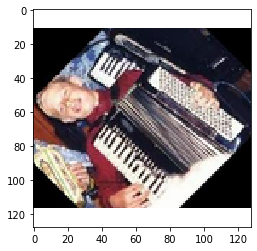

In [12]:
#show a image
plot_image(x_train_all[15])

## 2.6. Repartir Datos entre train-test-predic

In [13]:
print("Cantidad imagenes: ", len(x_train_all))
print("Cantidad etiquetas: ", len(y_train_all))

Cantidad imagenes:  9145
Cantidad etiquetas:  9145


In [14]:
processed_y = convertLabelsToNumbers(y_train_all)
salidasCategoricas = to_categorical(processed_y)

classesImageGenerator = np.unique(salidasCategoricas)
nClassesImageGenerator = len(salidasCategoricas[1])
print("Cantidad de categorias en las clases",nClassesImageGenerator)

Cantidad de categorias en las clases 102


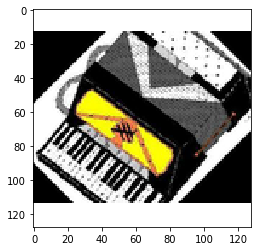

5 accordion


In [15]:
imagen = 7
plot_image(x_train_all[imagen])
print(processed_y[imagen], y_train_all[imagen])

In [16]:
classes = np.unique(processed_y)
nClasses = len(classes)

(X_train, y_train), (X_test, y_test), (X_predic, y_predic) = DividirDatos_Train_Test_Predic(x_train_all, processed_y)

print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", y_predic.shape)

print()
if y_predic.shape[1] == y_test.shape[1] and y_test.shape[1] == y_train.shape[1]:
    print("Distribución correcta")
else:
    print("Fallo en la distribución")

Datos para división recibidos
División todo el dataset en: train y test completa
División dataset test en: test y predict completa
Conversión de salidas en categorias completa
Training (66.98%)
X_train (6858, 128, 128, 3)
y_train (6858, 102)

Test (22.1%)
X_test (1715, 128, 128, 3)
y_test (1715, 102)

Predict (10.89%)
X_predic (572, 128, 128, 3)
y_predic (572, 102)

Distribución correcta


In [0]:
x_all = x_train_all
y_all = train_Y_one_hot = to_categorical(processed_y)

## 2.7. Aumentar el set de datos con DataGenerator (Opcional pero mejora los modelos cuando se utiliza)

### 2.7.1 Creando el modelo generador de datos

In [0]:
#Creamos el datagen del ImageDataGenerator para definir que cambios podria tener la imagen original

datagen = ImageDataGenerator(
    rotation_range=25, # grados de rotacion aleatoria
    width_shift_range=0.15, # fraccion del total (1) para mover la imagen
    height_shift_range=0.15, # fraccion del total (1) para mover la imagen
    shear_range=0.05, # deslizamiento
    zoom_range=0.1, # rango de zoom
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

### 2.7.2.Aplicando el data aumentation en el dataset original

In [19]:
cantidadConversiones = 2
#probado y funcionando con valor de 4, pero se requiere una buena GPU
#porque es facil superar la RAM maxima, y cuando se supera el colab ya no funciona



#También se incluirá la imagen original (en la practica no se suele usar la imagen original, pero para tener un dataset más grande en esta oportunidad la incluiremos)


if dataAumentationApliqued == False:
    print("Cantidad imagenes iniciales: ", len(X_train))
    print("Cantidad etiquetas iniciales: ", len(y_train))
    print("Tipo datos iniciales: ", type(X_train))
    listadoImagenes = []
    listaEtiquetasImagen = []
    for imagenProcesar in range(len(X_train)):    
        imagenConvertir = X_train[imagenProcesar] #elijo la imagen a usar de todo el dataset
        nombreImagen = y_train[imagenProcesar]
        listaConversiones, listaEtiquetasCadaConversion = ConverImageUsingImageDataGenerator(datagen, imagenConvertir, nombreImagen, cantidadConversiones-1)
        #añado las conversiones a la lista con append
        for i in range(len(listaConversiones)):
            listadoImagenes.append(listaConversiones[i])
            listaEtiquetasImagen.append(listaEtiquetasCadaConversion[i])

    #convierto la lista nuevamente a numpy para entregarla a los modelos
    X_train = convertListoToNumpy(listadoImagenes)
    y_train = convertListoToNumpy(listaEtiquetasImagen)
    print()
    print("Cantidad imagenes finales: ", len(X_train))
    print("Cantidad etiquetas finales: ", len(y_train))
    print("Tipo datos finales: ", type(X_train))
    dataAumentationApliqued = True
else:
    print("No se puede aplicar dataAumentation varias veces, si desea usarlo nuevamente, vuelva a reiniciar el colab (disponible en el menú de 'Entorno de ejecución').")

Cantidad imagenes iniciales:  6858
Cantidad etiquetas iniciales:  6858
Tipo datos iniciales:  <class 'numpy.ndarray'>

Cantidad imagenes finales:  13716
Cantidad etiquetas finales:  13716
Tipo datos finales:  <class 'numpy.ndarray'>


In [20]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 4:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 16.4 GB  | Proc size: 14.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


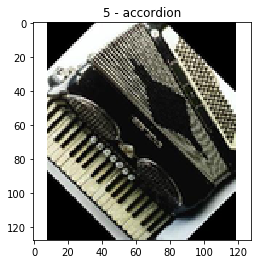

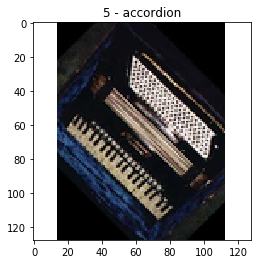

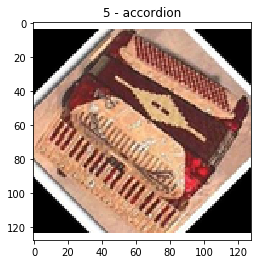

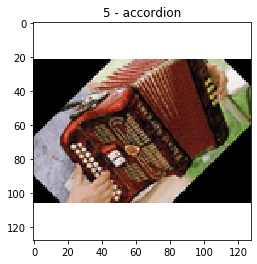

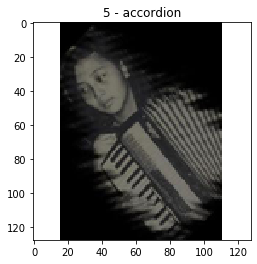

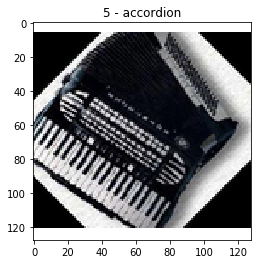

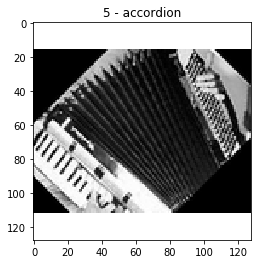

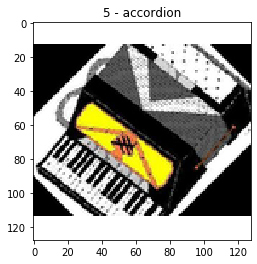

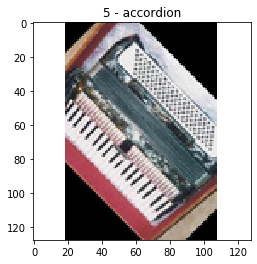

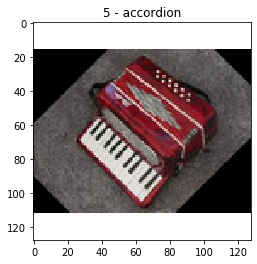

In [21]:
for imagen in range(10):
    titulo = str(processed_y[imagen]) + " - " + y_train_all[imagen]
    plot_image(x_train_all[imagen], titulo)

## 2.8. Repartir datos en valid y train

In [22]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 4:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 16.4 GB  | Proc size: 14.6 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [23]:
print(X_train.shape, y_train.shape)

(13716, 128, 128, 3) (13716, 102)


In [24]:
train_X, valid_X, train_label, valid_label = train_test_split(
        X_train, y_train, 
        test_size=0.2, 
        random_state=10)

print(X_train.shape, y_train.shape)
print(valid_X.shape, valid_label.shape)

(13716, 128, 128, 3) (13716, 102)
(2744, 128, 128, 3) (2744, 102)


In [25]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 4:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 11.0 GB  | Proc size: 20.0 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# 3. Nueva Red Neuronal

In [18]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 3:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 22.2 GB  | Proc size: 8.7 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
nombreModeloCreado = "wisrovi-nuevoModelo"
modelExtern = ModeloExterno(nombreModelo=nombreModeloCreado, rutaBase=BASE_FOLDER)

## 3.1. Modelo Red Neuronal

In [43]:
print("********** Modelo *********")
#MaxPooling2D es una forma de reducir el número de parámetros en nuestro modelo deslizando un filtro de agrupación de 2x2 a través de la capa anterior 
#y tomando el máximo de los 4 valores en el filtro de 2x2.

new_model = Sequential()
new_model.add( Conv2D(32,  kernel_size=(3, 3), activation='relu',padding='same', input_shape=(128,128,3))  )
new_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))

new_model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))

new_model.add( Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add( Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'  ) )
new_model.add(MaxPooling2D((2, 2),padding='same'))

new_model.add(Dropout(0.5)) #apagar un 50% de manera aleatoria para reducir la cantidad de parametros

new_model.add(Flatten()) #para aplanar todas las capas
new_model.add(Dense(96, activation='relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(96, activation='relu'))
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(nClasses, activation='softmax')) #Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion

new_model.summary()

new_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelExtern.GuardarModelo(new_model)

********** Modelo *********
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPoolin

True

## 3.2. Entrenar el modelo



Entrenamiento 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '





Train on 10972 samples, validate on 2744 samples
Epoch 1/11





10972/10972 [==============================] - 22s 2ms/step - loss: 4.0658 - acc: 0.1291 - val_loss: 3.7173 - val_acc: 0.2438
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 3.5132 - acc: 0.2447 - val_loss: 3.3133 - val_acc: 0.2744
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 3.3160 - acc: 0.2784 - val_loss: 3.1193 - val_acc: 0.3061
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 3.1581 - acc: 0.3011 - val_loss: 3.0417 - val_acc: 0.3189
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 3.0648 - acc: 0.3155 - val_loss: 2.9433 - val_acc: 0.3364
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.9674 - acc: 0.3285 - val_loss: 2.8574 - val_acc: 0.3539
Epoch 7/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.8920 - acc: 0.3438 - val_loss: 2.8022 - 

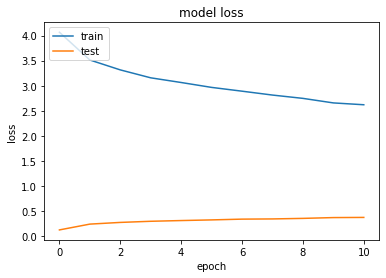

1715/1715 [==============================] - 1s 565us/step
Test loss: 2.4756389510874848
Test accuracy: 0.41690962102600854
Pesos Guardados!
***************



Entrenamiento 2
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
  160/10972 [..............................] - ETA: 12s - loss: 2.3319 - acc: 0.4688

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


10972/10972 [==============================] - 14s 1ms/step - loss: 2.5712 - acc: 0.3893 - val_loss: 2.5864 - val_acc: 0.4063
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.5143 - acc: 0.3972 - val_loss: 2.5399 - val_acc: 0.4085
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.4612 - acc: 0.4047 - val_loss: 2.4828 - val_acc: 0.4118
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.4054 - acc: 0.4154 - val_loss: 2.4659 - val_acc: 0.4151
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.3527 - acc: 0.4223 - val_loss: 2.5020 - val_acc: 0.4257
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.3087 - acc: 0.4281 - val_loss: 2.4544 - val_acc: 0.4165
Epoch 7/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.2880 - acc: 0.4315 - val_loss: 2.4311 - val_acc: 0.4322
Epoch 8/11
10972/10972 [============================

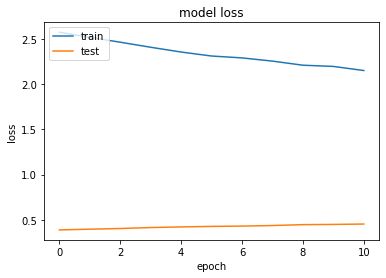

1715/1715 [==============================] - 1s 521us/step
Test loss: 2.1438269818141924
Test accuracy: 0.4868804664375483
Pesos Guardados!
***************



Entrenamiento 3
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.1053 - acc: 0.4643 - val_loss: 2.3824 - val_acc: 0.4395
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.0717 - acc: 0.4720 - val_loss: 2.3898 - val_acc: 0.4366
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.0593 - acc: 0.4728 - val_loss: 2.3955 - val_acc: 0.4391
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 2.0245 - acc: 0.4817 - val_loss: 2.4207 - val_acc: 0.4366
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.9921 - acc: 0.4885 - val_loss: 2.4131 - val_acc: 0.4446
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.9639 - acc

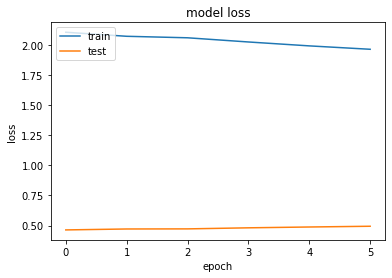

1715/1715 [==============================] - 1s 530us/step
Test loss: 2.107139580381855
Test accuracy: 0.4985422740177232
Pesos Guardados!
***************



Entrenamiento 4
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.8449 - acc: 0.5168 - val_loss: 2.3698 - val_acc: 0.4450
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.7990 - acc: 0.5253 - val_loss: 2.3607 - val_acc: 0.4519
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.7845 - acc: 0.5280 - val_loss: 2.3508 - val_acc: 0.4519
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.7750 - acc: 0.5301 - val_loss: 2.3555 - val_acc: 0.4552
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.7675 - acc: 0.5308 - val_loss: 2.3526 - val_acc: 0.4508
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.7587 - acc:

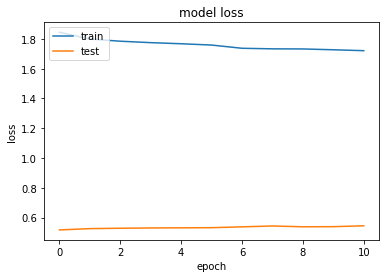

1715/1715 [==============================] - 1s 521us/step
Test loss: 2.069696747457321
Test accuracy: 0.5131195334929419
Pesos Guardados!
***************



Entrenamiento 5
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6693 - acc: 0.5491 - val_loss: 2.3501 - val_acc: 0.4566
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6969 - acc: 0.5495 - val_loss: 2.3540 - val_acc: 0.4566
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6876 - acc: 0.5489 - val_loss: 2.3505 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6771 - acc: 0.5473 - val_loss: 2.3560 - val_acc: 0.4592
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6671 - acc: 0.5538 - val_loss: 2.3566 - val_acc: 0.4592
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6863 - acc:

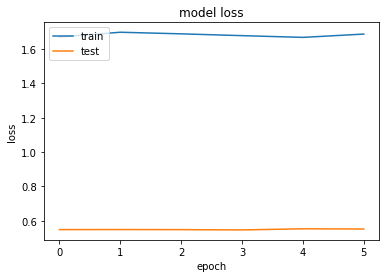

1715/1715 [==============================] - 1s 513us/step
Test loss: 2.074157099126032
Test accuracy: 0.5166180757669944
Pesos Guardados!
***************



Entrenamiento 6
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6826 - acc: 0.5460 - val_loss: 2.3544 - val_acc: 0.4599
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6681 - acc: 0.5506 - val_loss: 2.3545 - val_acc: 0.4599
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6788 - acc: 0.5502 - val_loss: 2.3548 - val_acc: 0.4595
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6738 - acc: 0.5532 - val_loss: 2.3546 - val_acc: 0.4595
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6748 - acc: 0.5515 - val_loss: 2.3544 - val_acc: 0.4588
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6809 - acc:

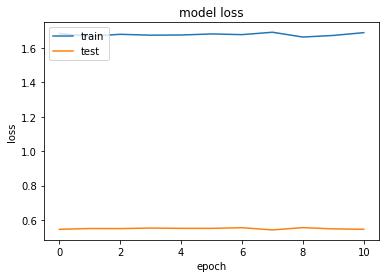

1715/1715 [==============================] - 1s 522us/step
Test loss: 2.0740279507011437
Test accuracy: 0.5148688046299681
***************



Entrenamiento 7
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6666 - acc: 0.5564 - val_loss: 2.3558 - val_acc: 0.4588
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6942 - acc: 0.5455 - val_loss: 2.3551 - val_acc: 0.4592
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6791 - acc: 0.5478 - val_loss: 2.3547 - val_acc: 0.4592
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6720 - acc: 0.5519 - val_loss: 2.3548 - val_acc: 0.4592
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6808 - acc: 0.5523 - val_loss: 2.3550 - val_acc: 0.4592
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6696 - acc: 0.5512 - val_lo

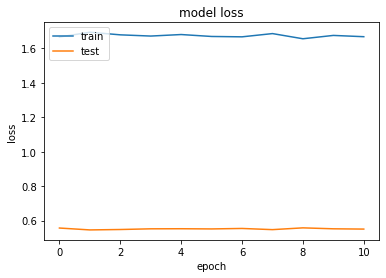

1715/1715 [==============================] - 1s 520us/step
Test loss: 2.0750657641157813
Test accuracy: 0.5137026238719506
***************



Entrenamiento 8
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6647 - acc: 0.5543 - val_loss: 2.3550 - val_acc: 0.4606
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6888 - acc: 0.5467 - val_loss: 2.3544 - val_acc: 0.4606
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6718 - acc: 0.5592 - val_loss: 2.3549 - val_acc: 0.4599
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6765 - acc: 0.5479 - val_loss: 2.3547 - val_acc: 0.4599
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6883 - acc: 0.5500 - val_loss: 2.3544 - val_acc: 0.4599
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6912 - acc: 0.5515 - val_lo

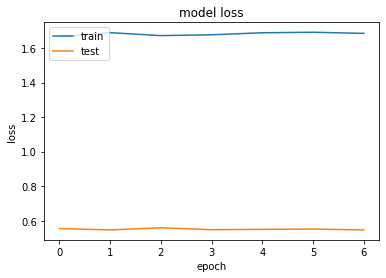

1715/1715 [==============================] - 1s 523us/step
Test loss: 2.07483164145022
Test accuracy: 0.5137026238719506
***************



Entrenamiento 9
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6784 - acc: 0.5517 - val_loss: 2.3550 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6731 - acc: 0.5477 - val_loss: 2.3550 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6654 - acc: 0.5515 - val_loss: 2.3549 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6636 - acc: 0.5543 - val_loss: 2.3549 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6841 - acc: 0.5465 - val_loss: 2.3549 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6806 - acc: 0.5480 - val_loss

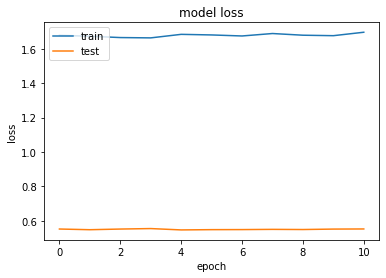

1715/1715 [==============================] - 1s 522us/step
Test loss: 2.074597623813952
Test accuracy: 0.5137026238719506
***************



Entrenamiento 10
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6729 - acc: 0.5517 - val_loss: 2.3547 - val_acc: 0.4599
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6673 - acc: 0.5486 - val_loss: 2.3546 - val_acc: 0.4599
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6852 - acc: 0.5473 - val_loss: 2.3546 - val_acc: 0.4599
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6622 - acc: 0.5499 - val_loss: 2.3547 - val_acc: 0.4599
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6754 - acc: 0.5494 - val_loss: 2.3546 - val_acc: 0.4599
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6905 - acc: 0.5442 - val_lo

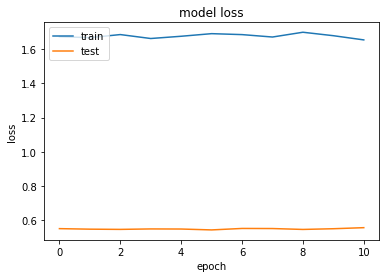

1715/1715 [==============================] - 1s 523us/step
Test loss: 2.0743928320553837
Test accuracy: 0.5125364431139332
***************



Entrenamiento 11
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6795 - acc: 0.5484 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6705 - acc: 0.5532 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6720 - acc: 0.5539 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6785 - acc: 0.5485 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6698 - acc: 0.5531 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6958 - acc: 0.5482 - val_l

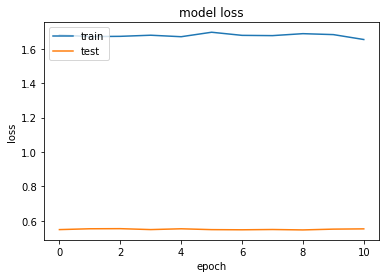

1715/1715 [==============================] - 1s 504us/step
Test loss: 2.0743467686127643
Test accuracy: 0.5125364431139332
***************



Entrenamiento 12
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6902 - acc: 0.5469 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6711 - acc: 0.5510 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6731 - acc: 0.5549 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6654 - acc: 0.5520 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6706 - acc: 0.5561 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6828 - acc: 0.5499 - val_l

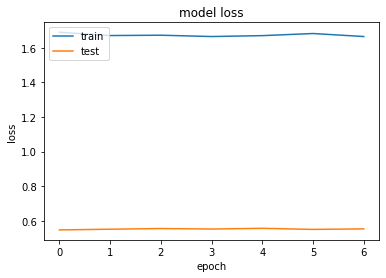

1715/1715 [==============================] - 1s 494us/step
Test loss: 2.0743466970176807
Test accuracy: 0.5125364431139332
***************



Entrenamiento 13
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6793 - acc: 0.5495 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6636 - acc: 0.5525 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6838 - acc: 0.5479 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6717 - acc: 0.5499 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6772 - acc: 0.5520 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6813 - acc: 0.5485 - val_l

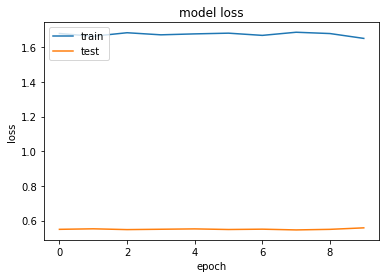

1715/1715 [==============================] - 1s 505us/step
Test loss: 2.0743466854790555
Test accuracy: 0.5125364431139332
***************



Entrenamiento 14
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6668 - acc: 0.5518 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6687 - acc: 0.5492 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6631 - acc: 0.5488 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6809 - acc: 0.5490 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6692 - acc: 0.5538 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6692 - acc: 0.5524 - val_l

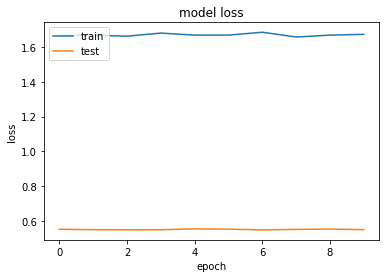

1715/1715 [==============================] - 1s 490us/step
Test loss: 2.074346678806116
Test accuracy: 0.5125364431139332
***************



Entrenamiento 15
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6660 - acc: 0.5532 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6782 - acc: 0.5503 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6695 - acc: 0.5531 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6672 - acc: 0.5520 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6728 - acc: 0.5439 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6741 - acc: 0.5551 - val_lo

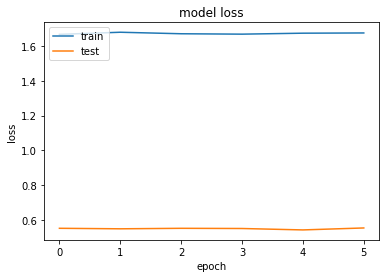

1715/1715 [==============================] - 1s 495us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 16
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6684 - acc: 0.5514 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6970 - acc: 0.5475 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6770 - acc: 0.5476 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6714 - acc: 0.5500 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6590 - acc: 0.5530 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6897 - acc: 0.5426 - val_l

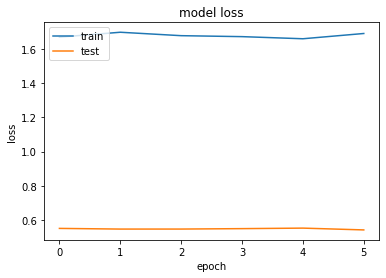

1715/1715 [==============================] - 1s 506us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 17
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6838 - acc: 0.5480 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6615 - acc: 0.5508 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6702 - acc: 0.5493 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6759 - acc: 0.5457 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6647 - acc: 0.5547 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6841 - acc: 0.5468 - val_l

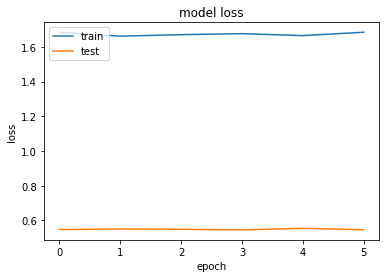

1715/1715 [==============================] - 1s 483us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 18
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6689 - acc: 0.5542 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6665 - acc: 0.5544 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6706 - acc: 0.5498 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6821 - acc: 0.5483 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6787 - acc: 0.5462 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6882 - acc: 0.5474 - val_l

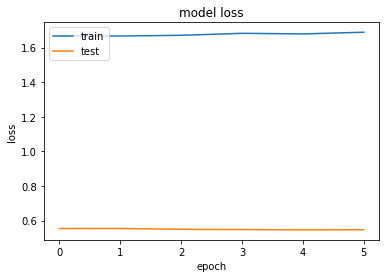

1715/1715 [==============================] - 1s 499us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 19
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6785 - acc: 0.5527 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6677 - acc: 0.5514 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6743 - acc: 0.5515 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6840 - acc: 0.5446 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6527 - acc: 0.5572 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6882 - acc: 0.5489 - val_l

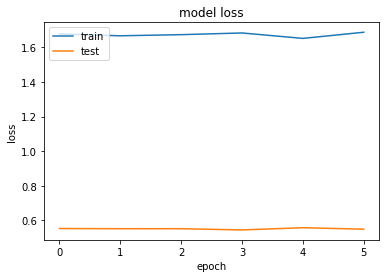

1715/1715 [==============================] - 1s 497us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 20
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6812 - acc: 0.5492 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6731 - acc: 0.5498 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6741 - acc: 0.5514 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6704 - acc: 0.5500 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6834 - acc: 0.5460 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6767 - acc: 0.5445 - val_l

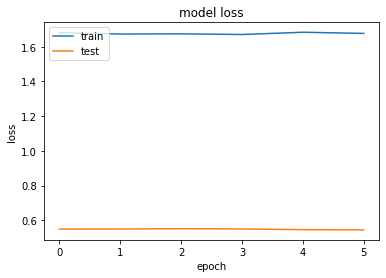

1715/1715 [==============================] - 1s 475us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 21
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6734 - acc: 0.5470 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6722 - acc: 0.5518 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6872 - acc: 0.5488 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6868 - acc: 0.5489 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6808 - acc: 0.5519 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6777 - acc: 0.5480 - val_l

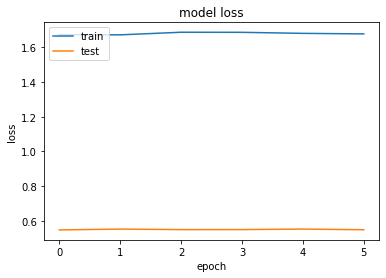

1715/1715 [==============================] - 1s 512us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 22
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6678 - acc: 0.5471 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6744 - acc: 0.5510 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6794 - acc: 0.5476 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6689 - acc: 0.5506 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6607 - acc: 0.5509 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6805 - acc: 0.5485 - val_l

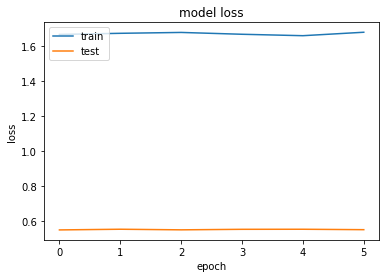

1715/1715 [==============================] - 1s 505us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 23
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6713 - acc: 0.5518 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6798 - acc: 0.5481 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6860 - acc: 0.5476 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6840 - acc: 0.5523 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6695 - acc: 0.5501 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6732 - acc: 0.5458 - val_l

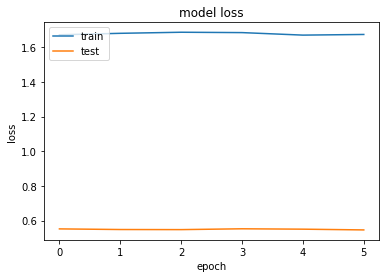

1715/1715 [==============================] - 1s 501us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 24
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6858 - acc: 0.5510 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6720 - acc: 0.5550 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6856 - acc: 0.5441 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6637 - acc: 0.5531 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6569 - acc: 0.5548 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6702 - acc: 0.5519 - val_l

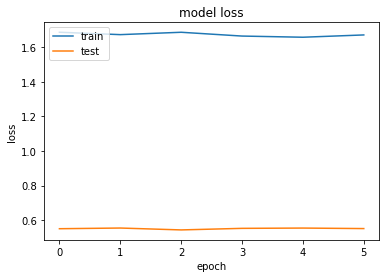

1715/1715 [==============================] - 1s 494us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 25
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6702 - acc: 0.5518 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6530 - acc: 0.5553 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6760 - acc: 0.5514 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6690 - acc: 0.5567 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6713 - acc: 0.5496 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6789 - acc: 0.5509 - val_l

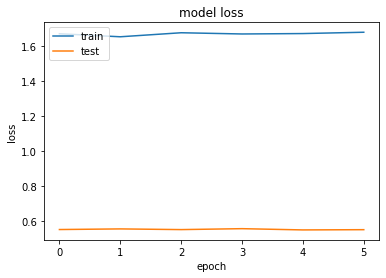

1715/1715 [==============================] - 1s 505us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 26
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6864 - acc: 0.5457 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6801 - acc: 0.5469 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6870 - acc: 0.5481 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6734 - acc: 0.5478 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6761 - acc: 0.5478 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6645 - acc: 0.5501 - val_l

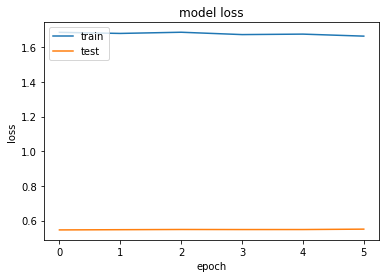

1715/1715 [==============================] - 1s 500us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 27
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6665 - acc: 0.5552 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6931 - acc: 0.5500 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6647 - acc: 0.5483 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6755 - acc: 0.5488 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6773 - acc: 0.5484 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6819 - acc: 0.5475 - val_l

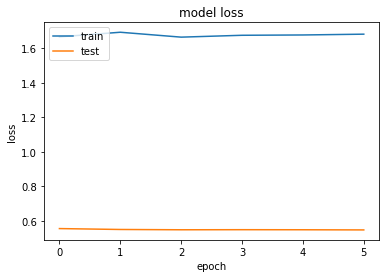

1715/1715 [==============================] - 1s 526us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 28
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6529 - acc: 0.5527 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6615 - acc: 0.5547 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6938 - acc: 0.5438 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6852 - acc: 0.5463 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6660 - acc: 0.5490 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6826 - acc: 0.5555 - val_l

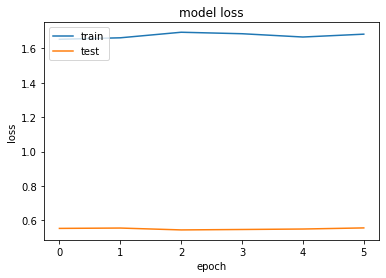

1715/1715 [==============================] - 1s 496us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 29
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6612 - acc: 0.5520 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6684 - acc: 0.5512 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6759 - acc: 0.5481 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6732 - acc: 0.5521 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6679 - acc: 0.5470 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6711 - acc: 0.5511 - val_l

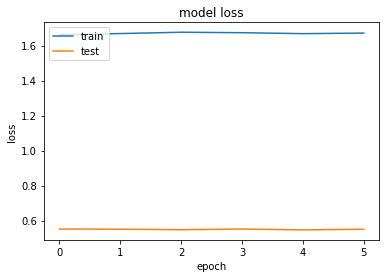

1715/1715 [==============================] - 1s 496us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 30
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6660 - acc: 0.5503 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6597 - acc: 0.5559 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6798 - acc: 0.5450 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6675 - acc: 0.5549 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6769 - acc: 0.5455 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6648 - acc: 0.5463 - val_l

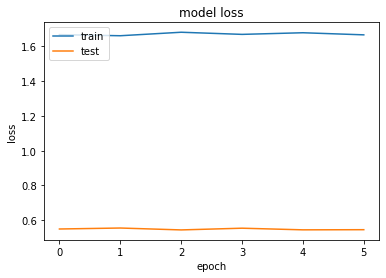

1715/1715 [==============================] - 1s 510us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 31
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6793 - acc: 0.5488 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6928 - acc: 0.5458 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6658 - acc: 0.5520 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6794 - acc: 0.5507 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6738 - acc: 0.5522 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6765 - acc: 0.5492 - val_l

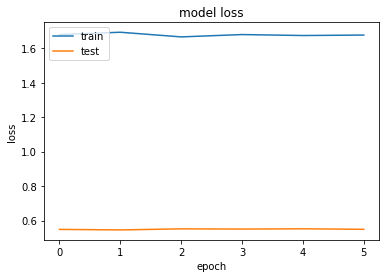

1715/1715 [==============================] - 1s 489us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 32
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6756 - acc: 0.5520 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6661 - acc: 0.5508 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6773 - acc: 0.5508 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6724 - acc: 0.5531 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6808 - acc: 0.5542 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6720 - acc: 0.5530 - val_l

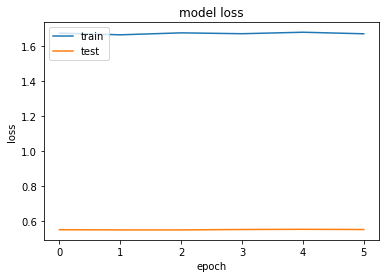

1715/1715 [==============================] - 1s 496us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 33
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6838 - acc: 0.5433 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6828 - acc: 0.5483 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6754 - acc: 0.5555 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6689 - acc: 0.5499 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6796 - acc: 0.5473 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6749 - acc: 0.5517 - val_l

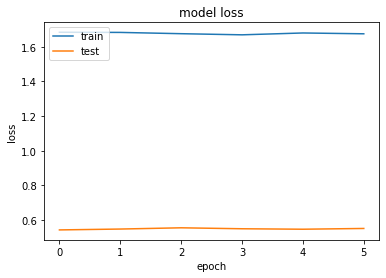

1715/1715 [==============================] - 1s 483us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 34
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6661 - acc: 0.5499 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6693 - acc: 0.5507 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6751 - acc: 0.5486 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6661 - acc: 0.5497 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6679 - acc: 0.5538 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6673 - acc: 0.5532 - val_l

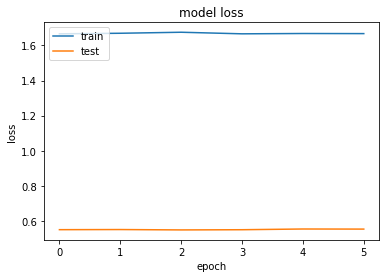

1715/1715 [==============================] - 1s 484us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 35
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6840 - acc: 0.5506 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6742 - acc: 0.5508 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6716 - acc: 0.5533 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6677 - acc: 0.5491 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6872 - acc: 0.5466 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6906 - acc: 0.5459 - val_l

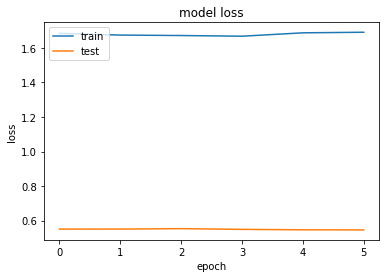

1715/1715 [==============================] - 1s 485us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 36
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6698 - acc: 0.5501 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6693 - acc: 0.5497 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6772 - acc: 0.5509 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6805 - acc: 0.5436 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6832 - acc: 0.5497 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6801 - acc: 0.5462 - val_l

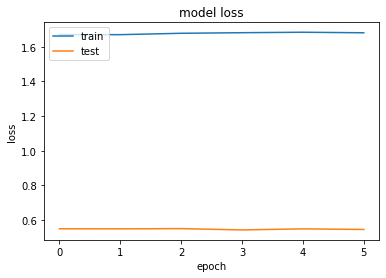

1715/1715 [==============================] - 1s 521us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 37
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6812 - acc: 0.5458 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6655 - acc: 0.5512 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6784 - acc: 0.5530 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6713 - acc: 0.5486 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6806 - acc: 0.5478 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6810 - acc: 0.5499 - val_l

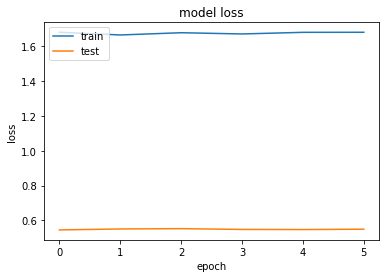

1715/1715 [==============================] - 1s 493us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 38
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6786 - acc: 0.5512 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6693 - acc: 0.5487 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6644 - acc: 0.5509 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6652 - acc: 0.5550 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6558 - acc: 0.5518 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6744 - acc: 0.5551 - val_l

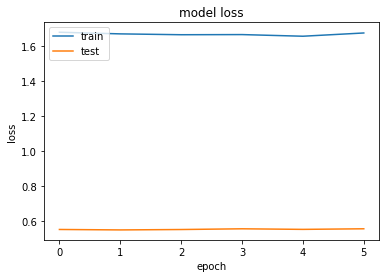

1715/1715 [==============================] - 1s 496us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 39
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6635 - acc: 0.5521 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6676 - acc: 0.5486 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6853 - acc: 0.5502 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6818 - acc: 0.5506 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6844 - acc: 0.5516 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6724 - acc: 0.5511 - val_l

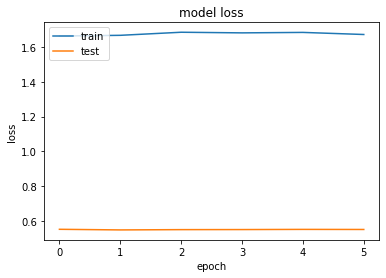

1715/1715 [==============================] - 1s 498us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 40
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6896 - acc: 0.5533 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6852 - acc: 0.5475 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6726 - acc: 0.5556 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6914 - acc: 0.5504 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6924 - acc: 0.5471 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6843 - acc: 0.5479 - val_l

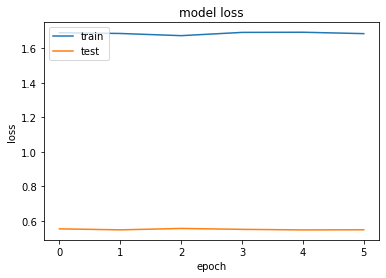

1715/1715 [==============================] - 1s 502us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 41
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6783 - acc: 0.5561 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6728 - acc: 0.5489 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6707 - acc: 0.5487 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6775 - acc: 0.5456 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6797 - acc: 0.5528 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6700 - acc: 0.5508 - val_l

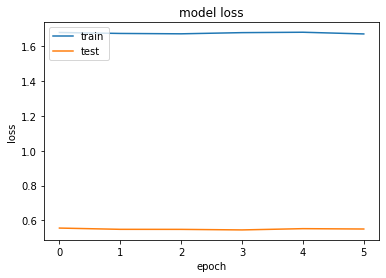

1715/1715 [==============================] - 1s 513us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 42
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6753 - acc: 0.5484 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6677 - acc: 0.5538 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6756 - acc: 0.5499 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6741 - acc: 0.5514 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6678 - acc: 0.5527 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6682 - acc: 0.5513 - val_l

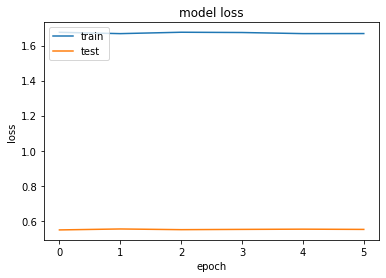

1715/1715 [==============================] - 1s 501us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 43
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6809 - acc: 0.5485 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6715 - acc: 0.5479 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6694 - acc: 0.5517 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6837 - acc: 0.5514 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6821 - acc: 0.5464 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6721 - acc: 0.5489 - val_l

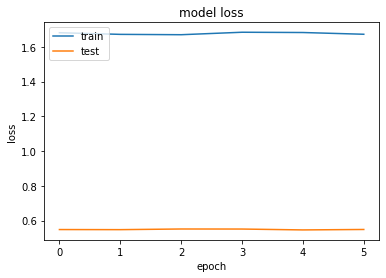

1715/1715 [==============================] - 1s 490us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 44
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6862 - acc: 0.5484 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6841 - acc: 0.5489 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6730 - acc: 0.5525 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6801 - acc: 0.5451 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6769 - acc: 0.5517 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6697 - acc: 0.5512 - val_l

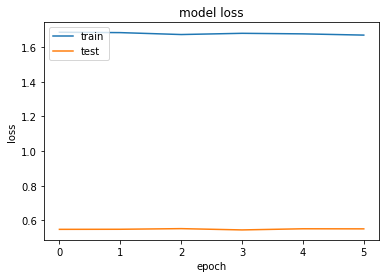

1715/1715 [==============================] - 1s 493us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 45
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6849 - acc: 0.5555 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6724 - acc: 0.5484 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6739 - acc: 0.5497 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6967 - acc: 0.5490 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6878 - acc: 0.5457 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6708 - acc: 0.5544 - val_l

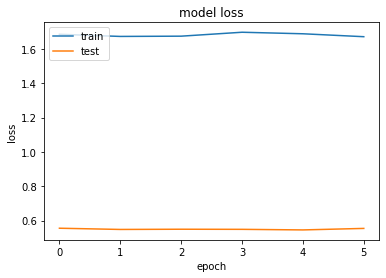

1715/1715 [==============================] - 1s 502us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 46
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6692 - acc: 0.5524 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6928 - acc: 0.5499 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6765 - acc: 0.5511 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6823 - acc: 0.5468 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6792 - acc: 0.5481 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6566 - acc: 0.5529 - val_l

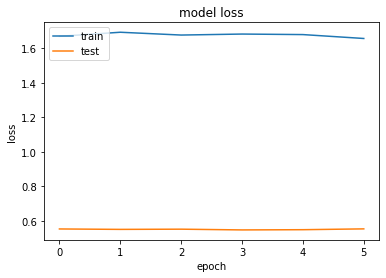

1715/1715 [==============================] - 1s 501us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 47
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6773 - acc: 0.5481 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6746 - acc: 0.5520 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6770 - acc: 0.5488 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 4/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6770 - acc: 0.5471 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 5/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6592 - acc: 0.5529 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 6/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6779 - acc: 0.5489 - val_l

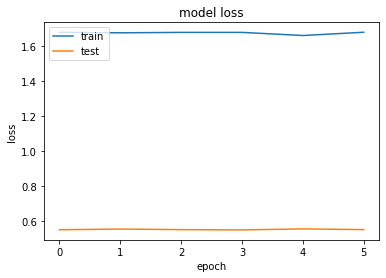

1715/1715 [==============================] - 1s 497us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332
***************



Entrenamiento 48
Train on 10972 samples, validate on 2744 samples
Epoch 1/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6617 - acc: 0.5503 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 2/11
10972/10972 [==============================] - 14s 1ms/step - loss: 1.6800 - acc: 0.5492 - val_loss: 2.3543 - val_acc: 0.4603
Epoch 3/11
10592/10972 [===========================>..] - ETA: 0s - loss: 1.6683 - acc: 0.5549Buffered data was truncated after reaching the output size limit.

In [29]:
#Entreno el modelo
numeroEntrenamientos = 50 #Al final de cada entrenamiento guardo los mejores pesos
numeroEpocas = 11  #ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = new_model.fit(
        train_X, train_label, 
        batch_size=32, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas, 
        verbose=1,
  
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback(nombreModeloCreado)
        )
        
    plot_history(history)
    
    test_eval = new_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelExtern.GuardarPesosModelo()
        oldModel = new_model
    else:
        new_model = oldModel
    print("***************")    
    print()

In [30]:
#valido el modelo
test_eval = new_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

1715/1715 [==============================] - 1s 490us/step
Test loss: 2.0743466899276823
Test accuracy: 0.5125364431139332


In [31]:
modelExtern.GuardarPesosModelo()

Pesos Guardados!


True

## 3.3 Cargar Modelo Red Neuronal Guardado (Nueva red neuronal desde cero)

In [20]:
modeloCargado = modelExtern.CargarModeloGuardado(False)
modeloCargado.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

Lectura del Json del modelo correcta
<class 'str'>





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Modelo Cargado!






Pesos Cargados!




In [41]:
print("*********************************************************************")
print("*                                                                   *")
print("*                      Modelo Creado desde cero                     *")
print("*                                                                   *")
print("*********************************************************************")
print()
print()

#valido el modelo
test_eval = modeloCargado.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 2
test_eval = modeloCargado.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 3
test_eval = modeloCargado.evaluate(x_all, y_all, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

*********************************************************************
*                                                                   *
*                      Modelo Creado desde cero                     *
*                                                                   *
*********************************************************************


1715/1715 [==============================] - 1s 452us/step
Test loss: 2.0743466899276823
Test accuracy: 51.25 %

572/572 [==============================] - 0s 451us/step
Test loss: 2.2185830177960697
Test accuracy: 51.92 %

9145/9145 [==============================] - 4s 456us/step
Test loss: 1.4647689426475956
Test accuracy: 63.77 %



# 4. Reentrenar un modelo de ImageNet

In [22]:
ramColab, GpuColab = getRam_y_Gpu(False)
if ramColab < 3:
    print("La Ram disponible no es suficiente para los entrenamientos de la red neuronal.")
else:
    getRam_y_Gpu(True)

Gen RAM Free: 21.8 GB  | Proc size: 9.5 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
nombreModeloTransferencia = "wisrovi-transferLearning"
modeloTrasnferenciaConocimiento = ModeloExterno(nombreModelo=nombreModeloTransferencia, rutaBase=BASE_FOLDER)

## 4.1 Cargar Modelo ImageNet

In [35]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## 4.2 Descongelar unas capas del Modelo ImageNet para reentrenarlas

In [36]:
congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()

<keras.engine.input_layer.InputLayer object at 0x7f6e982e3b38> False
<keras.layers.convolutional.Conv2D object at 0x7f6e982e39e8> False
<keras.layers.convolutional.Conv2D object at 0x7f6e982bd278> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6f023ba470> False
<keras.layers.convolutional.Conv2D object at 0x7f6e98358d30> False
<keras.layers.convolutional.Conv2D object at 0x7f6e9835f5c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6e98344438> False
<keras.layers.convolutional.Conv2D object at 0x7f6e98335860> False
<keras.layers.convolutional.Conv2D object at 0x7f6e98366b70> False
<keras.layers.convolutional.Conv2D object at 0x7f6e983556d8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6f026bb3c8> False
<keras.layers.convolutional.Conv2D object at 0x7f6f026b98d0> False
<keras.layers.convolutional.Conv2D object at 0x7f6f026c2a58> False
<keras.layers.convolutional.Conv2D object at 0x7f6f026d0940> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6f026cb208>

## 4.3. Crear nuestro modelo e incluirle el modelo de imageNet

In [38]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros


pre_trained_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )

pre_trained_model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'  ) )

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros

#para aplanar todas las capas
#esto se hace debido a que el modelo de VG16 nos da 4 dimensiones de salida, y con esto reducimos las dimensiones a dos: numero datos, numero clases
pre_trained_model.add(Flatten()) 

# conectarlo a nueva parte densa
# Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion
pre_trained_model.add(Dense(nClasses, activation='softmax')) 

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modeloTrasnferenciaConocimiento.GuardarModelo(pre_trained_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 32)          147488    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 102)              

True

## 4.4. Entrenar Modelo Con conocimiento Transferido

Int:  (10972, 128, 128, 3)
Out:  (10972, 102)


Entrenamiento 1


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 18s 2ms/step - loss: 3.2584 - acc: 0.2971 - val_loss: 2.5536 - val_acc: 0.4151
Epoch 2/15
10972/10972 [==============================] - 16s 1ms/step - loss: 2.2133 - acc: 0.4655 - val_loss: 1.8919 - val_acc: 0.5335
Epoch 3/15
10972/10972 [==============================] - 16s 1ms/step - loss: 1.5573 - acc: 0.5931 - val_loss: 1.4024 - val_acc: 0.6334
Epoch 4/15
10972/10972 [==============================] - 16s 1ms/step - loss: 1.1608 - acc: 0.6820 - val_loss: 1.4126 - val_acc: 0.6487
Epoch 5/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.8679 - acc: 0.7543 - val_loss: 1.0913 - val_acc: 0.7136
Epoch 6/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.7066 - acc: 0.7989 - val_loss: 1.0744 - val_acc: 0.7238
Epoch 7/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.5680 - acc: 0.8366 - val_loss: 1.0930 - val_acc:

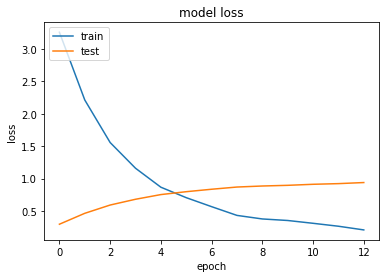

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2085168899669592
Test accuracy: 0.7877551023536103
Pesos Guardados!
***************



Entrenamiento 2
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
  128/10972 [..............................] - ETA: 13s - loss: 0.1877 - acc: 0.9531

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


10972/10972 [==============================] - 16s 1ms/step - loss: 0.0990 - acc: 0.9727 - val_loss: 0.9178 - val_acc: 0.8167
Epoch 2/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0472 - acc: 0.9881 - val_loss: 0.9231 - val_acc: 0.8240
Epoch 3/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0347 - acc: 0.9911 - val_loss: 0.9241 - val_acc: 0.8258
Epoch 4/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0316 - acc: 0.9923 - val_loss: 0.9637 - val_acc: 0.8262
Epoch 5/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0221 - acc: 0.9954 - val_loss: 0.9660 - val_acc: 0.8294
Epoch 6/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0192 - acc: 0.9959 - val_loss: 0.9983 - val_acc: 0.8309
dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


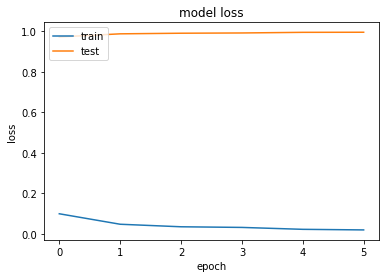

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.2065605793332914
Test accuracy: 0.8192419828200826
Pesos Guardados!
***************



Entrenamiento 3
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0177 - acc: 0.9966 - val_loss: 0.9934 - val_acc: 0.8316
Epoch 2/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0163 - acc: 0.9970 - val_loss: 0.9927 - val_acc: 0.8313
Epoch 3/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0165 - acc: 0.9965 - val_loss: 0.9958 - val_acc: 0.8320
Epoch 4/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0184 - acc: 0.9964 - val_loss: 0.9958 - val_acc: 0.8309
Epoch 5/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0162 - acc: 0.9972 - val_loss: 0.9953 - val_acc: 0.8327
Epoch 6/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0137 - acc: 

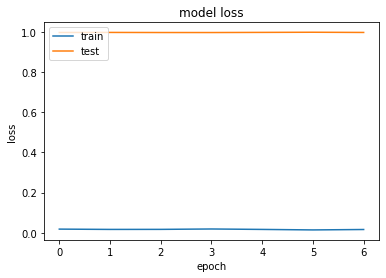

1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.212097154136302
Test accuracy: 0.8209912537138246
Pesos Guardados!
***************



Entrenamiento 4
Train on 10972 samples, validate on 2744 samples
Epoch 1/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0148 - acc: 0.9980 - val_loss: 0.9971 - val_acc: 0.8338
Epoch 2/15
10972/10972 [==============================] - 16s 1ms/step - loss: 0.0142 - acc: 0.9976 - val_loss: 0.9972 - val_acc: 0.8335
Epoch 3/15
 9536/10972 [=========================>....] - ETA: 1s - loss: 0.0136 - acc: 0.9980

In [0]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 30

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback(nombreModeloTransferencia)
        )
        
    plot_history(history)   

    test_eval = pre_trained_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modeloTrasnferenciaConocimiento.GuardarPesosModelo()
        oldModel = pre_trained_model
    else:
        pre_trained_model = oldModel
    print("***************")    
    print()

## 4.5. Cargar Modelo Red Neuronal Guardado (Transferencia conocimiento)

In [24]:
modeloCargadoTransferenciaConocimiento = modeloTrasnferenciaConocimiento.CargarModeloGuardado(False)
modeloCargadoTransferenciaConocimiento.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

Lectura del Json del modelo correcta
<class 'str'>
Modelo Cargado!
Pesos Cargados!


In [40]:
print("*********************************************************************")
print("*                                                                   *")
print("*           Modelo basado en transferencia de conocimiento          *")
print("*                                                                   *")
print("*********************************************************************")
print()
print()

#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 2
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

#valido el modelo 3
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(x_all, y_all, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy: %s %%' %( round(test_eval[1]*100, 2)))
print()

*********************************************************************
*                                                                   *
*           Modelo basado en transferencia de conocimiento          *
*                                                                   *
*********************************************************************
1715/1715 [==============================] - 2s 1ms/step
Test loss: 1.212097082610728
Test accuracy: 82.1 %

572/572 [==============================] - 1s 1ms/step
Test loss: 1.4380324912237954
Test accuracy: 80.77 %

9145/9145 [==============================] - 9s 1ms/step
Test loss: 0.43311155198649404
Test accuracy: 93.58 %



# 5. Conclusiones

Al usar la transferencia de conocimiento es más facil alcanzar un modelo de clasificacion óptimo para el objetivo propuesto en pocas epocas de reentrenamiento